# 5.2 구매 데이터를 분석하여 상품 추천하기

- 구매 데이터 분석에 기반한 온라인 스토어 상품 추천 시뮬레이션
- [feature engineering], [행렬 완성 기반 점수 예측 방법]을 이용하여 상품 추천 시뮬레이션 수행

## 1. 탐색적 데이터 분석 : UK Retail 데이터 분석


- 영국의 한 선물 판매 온라인 스토어에서 발생한 거래 데이터, 주 고객은 선물 도매상
```
InvoiceNo : 거래 고유 번호
StockCode : 상품 고유 번호
Description : 상품명
Quantity : 거래 수량
InvoiceDate : 거래 일시
UnitPrice : 상품 단가
CustomerID : 구매자 고유 번호
Country : 구매 국가
```

### 데이터 살펴보기

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive 

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/data/online_retail.csv', dtype={'CutomerID':str, 'InvoiceID':str}, encoding="ISO-8859-1")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%m/%d/%Y %H:%M")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

-> 약 54만 개 정도의 데이터 존재  
-> 14만 개의 데이터는 구매자 정보(CustomerID) 결측

### 결측 데이터 제거

In [6]:
df.dropna(inplace=True)
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [7]:
df.shape

(406829, 8)

### 탐색 데이터 조건 필터링

In [8]:
# 거래 수량이 없거나 음수인 경우 제거 
#(환불이나 주문 취소라고 추측하지만 명확하지 않으니 제거)
print(len(df[df['Quantity']<=0]))
df = df[df['Quantity']>0]

8905


In [9]:
# 상품 가격 0 이하인 경우 제거
print(len(df[df['UnitPrice']<=0]))
df = df[df['UnitPrice']>0]

40


In [10]:
# 상품 고유 번호(StockCode)가 일반적이지 않은 경우 
df['StockCode'].unique().tolist()

['85123A',
 '71053',
 '84406B',
 '84029G',
 '84029E',
 '22752',
 '21730',
 '22633',
 '22632',
 '84879',
 '22745',
 '22748',
 '22749',
 '22310',
 '84969',
 '22623',
 '22622',
 '21754',
 '21755',
 '21777',
 '48187',
 '22960',
 '22913',
 '22912',
 '22914',
 '21756',
 '22728',
 '22727',
 '22726',
 '21724',
 '21883',
 '10002',
 '21791',
 '21035',
 '22326',
 '22629',
 '22659',
 '22631',
 '22661',
 '21731',
 '22900',
 '21913',
 '22540',
 '22544',
 '22492',
 'POST',
 '22086',
 '20679',
 '37370',
 '21871',
 '21071',
 '21068',
 '82483',
 '82486',
 '82482',
 '82494L',
 '21258',
 '22114',
 '21733',
 '22386',
 '85099C',
 '21033',
 '20723',
 '84997B',
 '84997C',
 '21094',
 '20725',
 '21559',
 '22352',
 '21212',
 '21975',
 '21977',
 '84991',
 '84519A',
 '85183B',
 '85071B',
 '21931',
 '21929',
 '22961',
 '22139',
 '84854',
 '22411',
 '82567',
 '21672',
 '22774',
 '22771',
 '71270',
 '22262',
 '22637',
 '21934',
 '21169',
 '21166',
 '21175',
 '37444A',
 '37444C',
 '22083',
 '84971S',
 '47580',
 '22261

In [11]:
df['StockCode'].apply(lambda x: any(c.isdigit() for c in x)).sum()

396470

-> 대부분의 상품 고유 번호가 '번호'로 이루어져 있다. (396470개의 행)

In [12]:
df['ContainDigit'] = df['StockCode'].apply(lambda x: any(c.isdigit() for c in x))
print(df[df['ContainDigit']==False].shape[0])
df = df[df['ContainDigit']==True]

1414


### 본격적으로 EDA

__<연말에 온라인 스토어에 방문하는 유저들에게 어떤 상품을 추천해줄 수 있을까?>__ 
- 연말에 방문한 유저들에게 상품을 추천해준다. = 유저-상품 간의 구매 확률을 예측해보는 시뮬레이션
> 1) 연말 이전까지의 데이터를 유저-상품 간의 구매를 예측하는 모델의 학습 데이터셋으로 이용  
> 2) 실제 연말에 구매한 유저-상품 간의 정보를 테스트 데이터셋으로 사용  
> 3) 모델이 예측한 유저-상품 간의 구매 정보와 실제 구매 정보(테스트 데이터셋)을 비교하여 추천이 잘 되었는지 평가

- 특정 시간을 기준으로 데이터를 나누고, 데이터에서 구매 패턴과 같은 특징을 발견해보자!  
        => 일자별 주문(거래) 탐색

### 일자별 거래 데이터 분석

In [13]:
# 거래 데이터에서 가장 오래된 데이터와 가장 최신의 데이터 탐색
df['date'] = df['InvoiceDate'].dt.date # YYYY-MM-DD(문자)
print(df['date'].min())
print(df['date'].max())

2010-12-01
2011-12-09


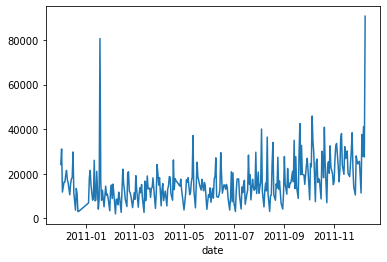

In [14]:
# 일자별 총 거래 수량 탐색 (거래 수량:Quantity)
date_quantity_series = df.groupby('date')['Quantity'].sum()
date_quantity_series.plot()

- 일자별 거래량을 시계열 그래프로 출력
- 연말에 가까워질수록 거래량이 증가하는 것을 볼 수 있다.
- 10-11월 정도를 기점으로 증가폭이 조금씩 커지고 있다는 것을 알 수 있다.

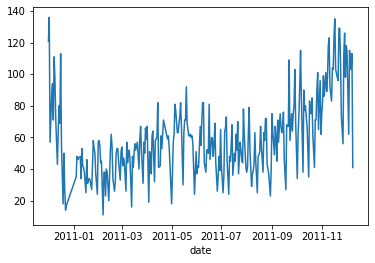

In [15]:
# 일자별 총 거래 횟수 (거래 고유 번호:InvoiceNo)
date_transaction_series = df.groupby('date')['InvoiceNo'].nunique()
date_transaction_series.plot()

- 일자별 거래 횟수 시계열 그래프로 나타냄
- 거래 횟수는 연말에 가까워질수록 거래 수량보다 조금 더 가파르게 상승

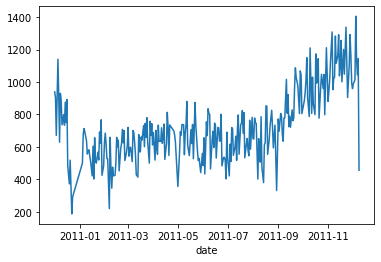

In [16]:
# 일자별 거래 상품 개수 탐색 (상품 고유 번호:StockCode)
# 일자별 거래된 상품의 unique한 갯수, 즉 상품 거래 다양성을 탐색
date_unique_item_series = df.groupby('date')['StockCode'].nunique()
date_unique_item_series.plot()

- 지금까지의 그래프 중 가장 가파른 상승세를 보이고 있음  

=> __결론__ : 연말이 시작되는 약 10-11월 정도부터 연중보다 더 많이 그리고 더 자주 구매가 일어난다는 것을 알 수 있다.

### 유저별 구매 패턴 분석


In [17]:
# 전체 유저의 수
df['CustomerID'].nunique()

4334

In [18]:
# (4334명의 유저 대상)유저별 거래 횟수
customer_unique_transaction_series = df.groupby('CustomerID')['InvoiceNo'].nunique()
customer_unique_transaction_series.describe()

count    4334.000000
mean        4.246654
std         7.642535
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       206.000000
Name: InvoiceNo, dtype: float64

-> 유저들 평균적으로 약 4회 정도의 구매가 있었다.  
-> 대부분의 유저는 1-5회 정도의 구매 횟수를 보인다.

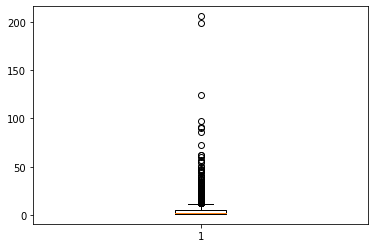

In [19]:
# 상자 그림으로 시각화
plt.boxplot(customer_unique_transaction_series.values)
plt.show()

In [20]:
# 유저별로 구매한 상품은 몇 종류나 되는지
customer_unique_item_series = df.groupby('CustomerID')['StockCode'].nunique()
customer_unique_item_series.describe()

count    4334.000000
mean       61.432856
std        85.312937
min         1.000000
25%        16.000000
50%        35.000000
75%        77.000000
max      1786.000000
Name: StockCode, dtype: float64

-> 유저들 평균적으로 약 60여 개 종류의 상품을 구매했다는 것을 알 수 있다.  
-> 하지만 데이터의 편차는 매우 높은 수치를 보이고 있음.

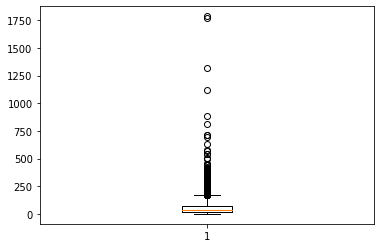

In [21]:
plt.boxplot(customer_unique_item_series.values)
plt.show()

-> 거래 횟수보다는 조금 더 다양하게 데이터가 분포돼 있는 것을 알 수 있다.

### 상품 기준 EDA

In [22]:
# 총 상품 갯수
df['StockCode'].nunique()

3660

In [23]:
# 가장 '거래 횟수' 많은 상품 top 10
df.groupby('StockCode')['InvoiceNo'].nunique().sort_values(ascending=False)[:10]

StockCode
85123A    1978
22423     1703
85099B    1600
47566     1379
84879     1375
20725     1289
22720     1146
23203     1080
20727     1052
22383     1043
Name: InvoiceNo, dtype: int64

count     3660.000000
mean      1409.149727
std       3513.654056
min          1.000000
25%         65.000000
50%        395.000000
75%       1417.500000
max      80995.000000
Name: Quantity, dtype: float64


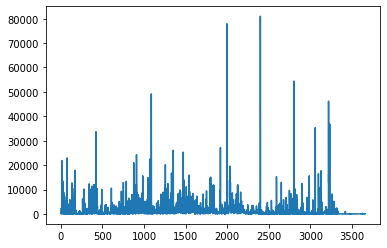

In [24]:
# 상품별 판매 수량 분포
print(df.groupby('StockCode')['Quantity'].sum().describe())
plt.plot(df.groupby('StockCode')['Quantity'].sum().values)
plt.show()

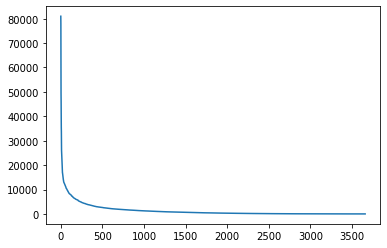

In [25]:
# 분포 정렬하여 출력
plt.plot(df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).values)
plt.show()

In [26]:
# 거래별 발생한 가격
df['amount'] = df['Quantity'] * df['UnitPrice']
df.groupby('InvoiceNo')['amount'].sum().describe()

count     18405.000000
mean        476.378845
std        1678.749892
min           0.380000
25%         157.900000
50%         302.360000
75%         465.700000
max      168469.600000
Name: amount, dtype: float64

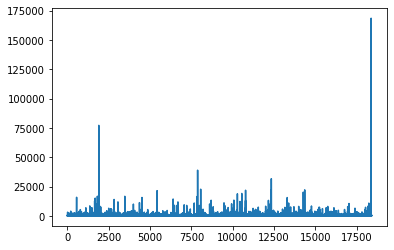

In [27]:
# 거래별 발생한 가격 분포
plt.plot(df.groupby('InvoiceNo')['amount'].sum().values)
plt.show()

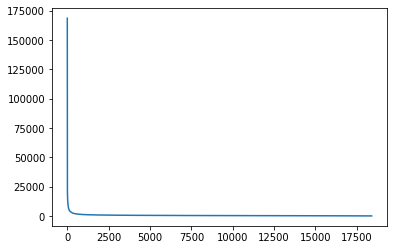

In [28]:
# 분포 정렬하여 출력
plt.plot(df.groupby('InvoiceNo')['amount'].sum().sort_values(ascending=False).values)
plt.show()

### 일자 기준으로 데이터 분리

- 특정 시점을 기준으로 데이터를 분리하여 구매의 패턴을 분석해보자  

<중점적으로 살펴볼 내용>  
> - 두 데이터에서 동일하게 등장하는 유저-상품 단위의 구매 데이터, 즉 __재구매 여부__
> - 신규 구매가 얼마나 일어났는지

- 먼저 11월 1일을 연말의 기준으로 삼아 두 개의 데이터로 분리한다.

In [29]:
import datetime

df_year_round = df[df['date'] < datetime.date(2011, 11, 1)]
df_year_end = df[df['date'] >= datetime.date(2011, 11, 1)]
print(df_year_round.shape)
print(df_year_end.shape)

(314902, 11)
(81568, 11)


- 분리된 데이터에서 재구매, 신규 구매 등이 어떻게 일어났는지 분석해보자

#### 11월(연말) 이전

In [30]:
# 11월 이전 데이터셋에서 유저별로 구매했던 상품의 set 추출
customer_item_round_set = df_year_round.groupby('CustomerID')['StockCode'].apply(set)
customer_item_round_set 

CustomerID
12346.0                                              {23166}
12347.0    {84559A, 17021, 84969, 23175, 20966, 23503, 20...
12348.0    {21985, 21983, 21213, 21967, 22951, 23077, 217...
12350.0    {21908, 79191C, 84086C, 22620, 79066K, 21864, ...
12352.0    {22801, 23298, 22413, 21756, 22979, 21314, 221...
                                 ...                        
18280.0    {22084, 22180, 82484, 22725, 22611, 22727, 224...
18281.0    {22028, 22716, 22037, 23007, 23008, 23209, 22467}
18282.0    {22089, 23187, 23295, 21270, 22424, 21108, 21109}
18283.0    {21931, 22197, 23298, 22439, 21213, 20712, 229...
18287.0    {22865, 21819, 84507C, 22752, 35967, 72351B, 2...
Name: StockCode, Length: 3970, dtype: object

In [31]:
# 유저가 상품을 11월 이전에 구매했는지 혹은 11월 이후에 구매했는지를 기록하기 위한 
# 유저-상품 단위의 딕셔너리 정의
customer_item_dict = {}

# 11월 이전에 구매한 상품은 'old'라고 표기
for customer_id, stocks in customer_item_round_set.items():
    customer_item_dict[customer_id] = {}
    for stock_code in stocks:
        customer_item_dict[customer_id][stock_code] = 'old'
        
print(str(customer_item_dict)[:100] + '...')

{12346.0: {'23166': 'old'}, 12347.0: {'84559A': 'old', '17021': 'old', '84969': 'old', '23175': 'old...


#### 11월(연말) 이후

In [32]:
# 11월 이후 데이터셋에서 유저별로 구매했던 상품의 set 추출
customer_item_end_set = df_year_end.groupby('CustomerID')['StockCode'].apply(set)
customer_item_end_set

CustomerID
12347.0    {23084, 21731, 21265, 21064, 23508, 23497, 235...
12349.0    {85014B, 47504H, 22071, 23112, 21563, 35970, 2...
12352.0    {22668, 22627, 23559, 22624, 21669, 22982, 233...
12356.0                                       {21843, 22423}
12357.0    {22846, 23184, 22964, 37449, 22815, 21843, 223...
                                 ...                        
18272.0    {22966, 72799C, 22666, 22961, 22993, 20914, 22...
18273.0                                             {79302M}
18274.0    {23243, 84509A, 21231, 22851, 22423, 21108, 22...
18282.0                  {22818, 22423, 23175, 23174, 22699}
18283.0    {21931, 21213, 20712, 20719, 22367, 23320, 235...
Name: StockCode, Length: 1904, dtype: object

In [33]:
# 11월 이전에만 구매한 상품은 'old'
# 이후에만 구매한 상품은 'new'
# 모두 구매한 상품은 'both'라고 표기

for customer_id, stocks in customer_item_end_set.items():
    # 11월 이전 구매 기록 있는 유저인지 체크
    if customer_id in customer_item_dict: # CustomerID
        for stock_code in stocks:
            # 구매한 적 있는 상품인지 체크 -> 상태 표기
            if stock_code in customer_item_dict[customer_id]:
                customer_item_dict[customer_id][stock_code] = 'both'
            else:
                customer_item_dict[customer_id][stock_code] = 'new'
    else:
        customer_item_dict[customer_id] = {}
        for stock_code in stocks:
            customer_item_dict[customer_id][stock_code] = 'new'
            
print(str(customer_item_dict)[:100] + '...')     

{12346.0: {'23166': 'old'}, 12347.0: {'84559A': 'old', '17021': 'old', '84969': 'old', '23175': 'old...


In [34]:
# 데이터프레임 형태로 다시 정리

columns = ['CustomerID', 'old', 'new', 'both']
df_order_info = pd.DataFrame(columns=columns)

for customer_id in customer_item_dict:
    old = 0
    new = 0
    both = 0
    
    for stock_code in customer_item_dict[customer_id]:
        status = customer_item_dict[customer_id][stock_code]
        if status == 'old':
            old += 1
        elif status == 'new':
            new += 1
        else:
            both += 1
            
    row = [customer_id, old, new, both]
    series = pd.Series(row, index=columns)
    df_order_info = df_order_info.append(series, ignore_index=True)
    
df_order_info.head()

,CustomerID,old,new,both
0,12346.0,1.0,0.0,0.0
1,12347.0,92.0,3.0,8.0
2,12348.0,21.0,0.0,0.0
3,12350.0,16.0,0.0,0.0
4,12352.0,43.0,12.0,2.0


- 정리된 데이터 프레임을 활용하여 재구매와 신규 구매가 어떤 패턴으로 발생했는지 탐색해보자

In [35]:
# 전체 유저의 수 4334명
df_order_info.shape[0]

4334

In [36]:
# 11월 이전 구매 내역이 있으면서 11월 이후 기존에 구매한 적 없는 새로운 상품 구매한 유저의 수
df_order_info[(df_order_info['old']>0) & (df_order_info['new']>0)].shape[0]

1446

-> 11월 이후 기존에 구매한 적 없던 신규 상품을 구매한 유저가 약 1/3 가량 된다.

In [37]:
# 재구매한 상품이 있는 유저의 수 
df_order_info[df_order_info['both']>0].shape[0]

1426

-> 1/3 정도는 11월 이전에 구매했던 상품을 11월 이후에 다시 구매한다.

In [38]:
# 신규 구매한 상품 있는 유저들은 새로운 상품을 얼마나 구매하는지
df_order_info['new'].value_counts()

0.0      2521
1.0        81
3.0        73
2.0        72
8.0        65
         ... 
118.0       1
172.0       1
98.0        1
108.0       1
196.0       1
Name: new, Length: 133, dtype: int64

In [39]:
# 만약 새로운 상품을 구매한다면, 얼마나 많은 종류의 새로운 상품을 구매하는지
df_order_info['new'].value_counts()[1:].describe()

count    132.000000
mean      13.734848
std       19.130672
min        1.000000
25%        1.000000
50%        5.000000
75%       16.000000
max       81.000000
Name: new, dtype: float64

-> 평균적으로 13개 종류의 신규 상품을 구매하는 것으로 나타남  
-> 하지만 이는 편차가 매우 큰 것으로 보인다.  
=> __결론__ : 신규 구매를 하는 유저들은 일반적으로 많은 종류의 상품을 구매하지는 않을 것으로 예상할 수 있다. 

## 2. 예측 분석 : SVD를 활용한 상품 구매 예측

- 상품 추천 시뮬레이션 = 과거의 학습 데이터셋을 이용하여 미래의 유저-상품 구매를 예측하는 것
- Chapter3에서 학습한 '미래에 볼 영화의 평점 예측하기'와 동일한 방식으로 수행할 수 있다. 
- Chapter3에서는 특정 시점 이전의 데이터로 SVD 모델을 학습하고, 이를 통해 특점 시점 이후의 유저-아이템의 점수를 예측했다. 
- 마찬가지로 이번 예제에서도 유저-상품의 점수를 예측하여 상품 추천에 활용해보자

> SVD 예측 모델 학습을 진행하기에 앞서 학습 데이터인 11월 이전의 데이터에서 추천 대상이 되는 유저와 상품은 얼마나 되는지를 탐색해보자.

In [40]:
# 추천 대상인 유저와 상품의 개수 출력
print(len(df_year_round['CustomerID'].unique()))
print(len(df_year_round['StockCode'].unique()))

3970
3608


- SVD 모델을 학습함에 있어 Chapter3에서의 내용과 한 가지 다른 점  
: 현재 유저-아이템의 'Rating'에 해당하는 선호도 점수를 가지고 있지 않다.  
- 해결 방법 : feature engineering을 통해 이 점수를 만들어내야 함!
- 적당한 유저-상품 간의 점수(Rating)를 만들어 내기 위해 위의 분석 결과 중 __'유저별 구매 횟수는 일반적으로 1-5 사이에 분포되어 있음'__ 참고
- 따라서 이 정보를 활용하여 유저-상품 간의 구매 횟수가 Rating으로 사용하기에 적절한지를 탐색해 볼 것이다.
- 유저별 구매 횟수가 일반적으로 1-5 사이라면 유저-상품 간의 구매 횟수 역시 크게 다르지 않을 것이기 때문.

### SVD 모델에 사용할 유저-상품 간의 Rating 데이터 생성 

In [41]:
# 유저-상품 간의 구매 횟수 탐색하여 U-I-R 데이터로 활용할 데이터 프레임 생성
uir_df = df_year_round.groupby(['CustomerID', 'StockCode'])['InvoiceNo'].nunique().reset_index()
uir_df.head()

,CustomerID,StockCode,InvoiceNo
0,12346.0,23166,1
1,12347.0,16008,1
2,12347.0,17021,1
3,12347.0,20665,1
4,12347.0,20719,3


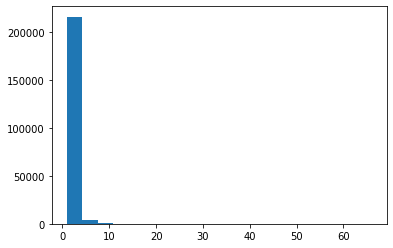

In [42]:
# Rating(InvoiceNo) 분포 탐색
uir_df['InvoiceNo'].hist(bins=20, grid=False)

-> 대부분의 점수가 1-5 사이에 위치하긴 하지만 점수가 낮은 쪽으로 많이 쏠려있는 것을 확인할 수 있다.  
-> 아마도 이러한 분포를 가진 Rating으로 SVD 모델을 학습한다면 행렬을 제대로 완성하지 못할 확률 높음  
-> 이런 상황에 적용할 수 있는 feature engineering 기법으로 로그를 통한 feature 정규화 방법이 있다. __(Log Normalization)__  

- __(Log Normalization)__  
: 위처럼 데이터의 왜도 (skewness: 한쪽으로 긴 꼬리를 가진 형태의 비대칭적인 분포 정도)가 높은 경우에 '데이터 사이의 편차를 줄여 왜도를 감소시키는 것'에 있다.  
: 이는 로그라는 개념의 수학적인 성질에 기반하는 것.

#### Log Normalization

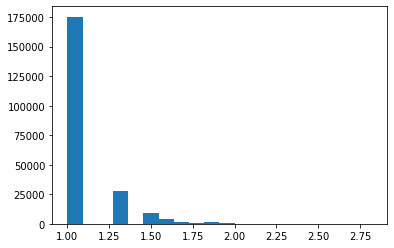

In [43]:
uir_df['InvoiceNo'].apply(lambda x: np.log10(x)+1).hist(bins=20, grid=False)

-> 여전히 왜도가 높긴 하지만 적용 이전에 비해서는 feature를 rating으로 쓰기에 조금 더 적합해졌다는 것을 알 수 있다.

#### 1~5 사이의 값으로 변환 (최대-최소 스케일링 방법 적용)


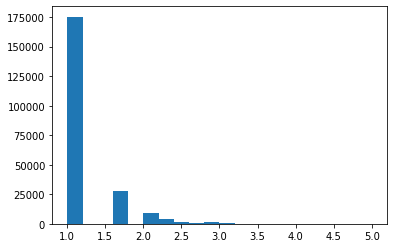

In [44]:
uir_df['Rating'] = uir_df['InvoiceNo'].apply(lambda x:np.log10(x)+1)
uir_df['Rating'] = ((uir_df['Rating'] - uir_df['Rating'].min()) / (uir_df['Rating'].max() - uir_df['Rating'].min()) * 4) + 1
uir_df['Rating'].hist(bins=20, grid=False)

### SVD 모델 학습

In [45]:
# SVD 모델 학습 위한 데이터셋 생성
uir_df = uir_df[['CustomerID', 'StockCode', 'Rating']]
uir_df.head()

,CustomerID,StockCode,Rating
0,12346.0,23166,1.000000
1,12347.0,16008,1.000000
2,12347.0,17021,1.000000
3,12347.0,20665,1.000000
4,12347.0,20719,2.048881


In [46]:
! pip install surprise

     |████████████████████████████████| 11.8MB 6.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1618286 sha256=50ddccf49f9a0bee4b85649307af5a99e26f5417af12ad1684df11166899a22d
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [47]:
import time
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# SVD 라이브러리를 사용하기 위한 train data 생성
# 대략적인 성능을 알아보기 위해 train data : test data = 8 : 2로 분할
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(uir_df[['CustomerID', 'StockCode', 'Rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

# SVD 모델 학습
train_start = time.time()
model = SVD(n_factors=8,
           lr_all=0.005,
           reg_all=0.02,
           n_epochs=200)
model.fit(train_data)
train_end = time.time()
print('training time of model: %.2f 초' %(train_end-train_start))

predictions = model.test(test_data)

print('SVD 모델에서 test dataset의 RMSE : ')
accuracy.rmse(predictions)

training time of model: 31.61 초
SVD 모델에서 test dataset의 RMSE : 
RMSE: 0.3384


0.3384449641161093

-> 모델의 대략적인 성능을 알아보았다.  
-> 이제 11월 데이터를 모두 train data로만 사용하여 모델 학습

In [48]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(uir_df[['CustomerID', 'StockCode', 'Rating']], reader)
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=200)
model.fit(train_data)
train_end = time.time() 
print('training time of model: %.2f 초' %(train_end-train_start))

training time of model: 32.03 초


## 3. 예측 평가 : 상품 추천 시뮬레이션

- 추천의 대상이 되는 __유저__ : 11월 이전 데이터에 등장한 모든 유저 
- 유저들에게 추천의 대상이 되는 __상품__ :
> 1) 이전에 구매한 적 없던 상품 추천 : 신규 구매를 타겟으로 하는 추천  
> 2) 이전에 구매했던 상품 추천 : 재구매를 타겟으로 하는 추천  
> 3) 모든 대상을 대상으로 상품 추천 : 모든 유저-상품의 점수를 고려하여 추천

### 1) 이전에 구매한 적 없던 상품 추천 : 신규 구매를 타겟으로 하는 추천

In [49]:
# 이전에 구매하지 않았던 상품을 예측의 대상으로 선정
test_data = train_data.build_anti_testset()
target_user_predictions = model.test(test_data)

# 구매 예측 결과를 딕셔너리 형태로 변환
new_order_prediction_dict = {}
for customer_id, stock_code, _, predicted_rating, _ in target_user_predictions:
    if customer_id in new_order_prediction_dict:
        if stock_code in new_order_prediction_dict[customer_id]:
            pass
        else:
            new_order_prediction_dict[customer_id][stock_code] = predicted_rating
    else:
        new_order_prediction_dict[customer_id] = {}
        new_order_prediction_dict[customer_id][stock_code] = predicted_rating

print(str(new_order_prediction_dict)[:300] + "...")

{15786.0: {'22779': 1.1337991184613467, '23194': 1.0184632008311285, '22147': 1.0804415463799155, '84978': 1.1080174983440991, '21429': 1.1568050947213957, '84997B': 1.1734393773114906, '23373': 1, '23406': 1, '21894': 1, '22113': 1.109010928578594, '22756': 1, '22818': 1.0070259738512322, '23168': ...


### 2) 이전에 구매했던 상품 추천 : 재구매를 타겟으로 하는 추천

In [50]:
test_data = train_data.build_testset()
target_user_predictions = model.test(test_data)

# 구매 예측 결과를 딕셔너리 형태로 변환
reorder_prediction_dict = {}
for customer_id, stock_code, _, predicted_rating, _ in target_user_predictions:
    if customer_id in reorder_prediction_dict:
        if stock_code in reorder_prediction_dict[customer_id]:
            pass
        else:
            reorder_prediction_dict[customer_id][stock_code] = predicted_rating
    else:
        reorder_prediction_dict[customer_id] = {}
        reorder_prediction_dict[customer_id][stock_code] = predicted_rating
        
print(str(reorder_prediction_dict)[:300] + "...")

{15786.0: {'22908': 1.0700681358977888, '21977': 1, '21124': 1.061598538566271, '23079': 1.0571581952702274, '23112': 1.059899546074327, '22738': 1.0231109439949453, '23354': 1.0256047206907373, '21982': 1.0413716882005333, '23534': 1.0271882515384274, '22951': 1.012975424536914, '23034': 1, '47590B...


### 3) 모든 대상을 대상으로 상품 추천 : 모든 유저-상품의 점수를 고려하여 추천

In [51]:
# 두 딕셔너리를 하나로 통합
total_prediction_dict = {}

# new_order_prediction_dict 정보를 새로운 딕셔너리에 저장
for customer_id in new_order_prediction_dict:
    if customer_id not in total_prediction_dict:
        total_prediction_dict[customer_id] = {}
    for stock_code, predicted_rating in new_order_prediction_dict[customer_id].items():
        if stock_code not in total_prediction_dict[customer_id]:
            total_prediction_dict[customer_id][stock_code] = predicted_rating
            
# reorder_prediction_dict 정보를 새로운 딕셔너리에 저장
for customer_id in reorder_prediction_dict:
    if customer_id not in total_prediction_dict:
        total_prediction_dict[customer_id] = {}
    for stock_code, predicted_rating in reorder_prediction_dict[customer_id].items():
        if stock_code not in total_prediction_dict[customer_id]:
            total_prediction_dict[customer_id][stock_code] = predicted_rating
            
print(str(total_prediction_dict)[:300] + "...")

{15786.0: {'22779': 1.1337991184613467, '23194': 1.0184632008311285, '22147': 1.0804415463799155, '84978': 1.1080174983440991, '21429': 1.1568050947213957, '84997B': 1.1734393773114906, '23373': 1, '23406': 1, '21894': 1, '22113': 1.109010928578594, '22756': 1, '22818': 1.0070259738512322, '23168': ...


- 위에서 생성한 두 개의 딕셔너리를 하나의 딕셔너리로 통합하는 과정으로 생성할 수 있다.

In [52]:
# 11월 이후의 데이터를 테스트 데이터셋으로 사용하기 위한 데이터프레임을 생성
simulation_test_df = df_year_end.groupby('CustomerID')['StockCode'].apply(set).reset_index()
simulation_test_df.columns = ['CustomerID', 'RealOrdered']
simulation_test_df.head()

,CustomerID,RealOrdered
0,12347.0,"{23084, 21731, 21265, 21064, 23508, 23497, 235..."
1,12349.0,"{85014B, 47504H, 22071, 23112, 21563, 35970, 2..."
2,12352.0,"{22668, 22627, 23559, 22624, 21669, 22982, 233..."
3,12356.0,"{21843, 22423}"
4,12357.0,"{22846, 23184, 22964, 37449, 22815, 21843, 223..."


### 시뮬레이션 결과와 실제 구매가 얼마나 유사한지 평가

- 11월 이후의 데이터를 test data로 활용하기 위해 각 유저들이 11월 이후에 실제로 구매한 상품의 리스트를 데이터 프레임의 형태로 정리

In [53]:
# 이 데이터프레임에 상품 추천 시뮬레이션 결과를 추가하기 위한 함수를 정의
def add_predicted_stock_set(customer_id, prediction_dict):
    if customer_id in prediction_dict:
        predicted_stock_dict = prediction_dict[customer_id]
        # 예측된 상품의 Rating이 높은 순으로 정렬
        sorted_stocks = sorted(predicted_stock_dict, key=lambda x : predicted_stock_dict[x], reverse=True)
        return sorted_stocks
    else:
        return None

# 상품 추천 시뮬레이션 결과를 추가
simulation_test_df['PredictedOrder(New)'] = simulation_test_df['CustomerID']. \
                                            apply(lambda x: add_predicted_stock_set(x, new_order_prediction_dict))
simulation_test_df['PredictedOrder(Reorder)'] = simulation_test_df['CustomerID']. \
                                            apply(lambda x: add_predicted_stock_set(x, reorder_prediction_dict))
simulation_test_df['PredictedOrder(Total)'] = simulation_test_df['CustomerID']. \
                                            apply(lambda x: add_predicted_stock_set(x, total_prediction_dict))
simulation_test_df.head()

,CustomerID,RealOrdered,PredictedOrder(New),PredictedOrder(Reorder),PredictedOrder(Total)
0,12347.0,"{23084, 21731, 21265, 21064, 23508, 23497, 235...","[22995, 21935, 79321, 22467, 84086B, 22998, 82...","[22726, 22725, 22728, 22727, 20719, 22729, 223...","[22726, 22995, 22725, 21935, 22728, 22727, 207..."
1,12349.0,"{85014B, 47504H, 22071, 23112, 21563, 35970, 2...",None,None,None
2,12352.0,"{22668, 22627, 23559, 22624, 21669, 22982, 233...","[84086B, 72709, 46115B, 22171, 22928, 90151, 8...","[22779, 22780, 22634, 22801, 21754, 22654, 217...","[84086B, 72709, 46115B, 22171, 22928, 90151, 8..."
3,12356.0,"{21843, 22423}","[84086B, 72709, 90035A, 85099B, 46115B, 79321,...","[37450, 22649, 84991, 21080, 21213, 21527, 226...","[84086B, 72709, 90035A, 85099B, 46115B, 79321,..."
4,12357.0,"{22846, 23184, 22964, 37449, 22815, 21843, 223...",None,None,None


- 평가 방식  
> 1) 유저별로 예측된 상품의 점수 순으로 상위 k개의 상품을 추천 대상으로 정의  
> 2) 추천한 k개의 상품 중, 실제 구매로 얼마만큼 이어졌는지 평가  

- 이 방식은 Chapter4에서 학습했던 분류 모델의 평가 방법 중 하나인 recall과 동일한 개념이다. (다만, k개의 대상으로 제한한다는 것이 다를 뿐)

In [54]:
# 구매 예측의 상위k개의 recall(재현율)을 평가 기준으로 정의
def calculate_recall(real_order, predicted_order, k):
  # 만약 추천 대상 상품이 없으면, 11월 이후 상품을 처음 구매하는 유저임.
  if predicted_order is None:
    return None

  # SVD 모델에서 현재 유저의 Rating이 높은 상위 k개의 상품을 '구매할 것으로 예측'한다.
  predicted = predicted_order[:k]
  true_positive = 0
  for stock_code in predicted:
    if stock_code in real_order:
      true_positive += 1

  # 예측한 상품 중, 실제로 유저가 구매한 상품의 비율(recall)을 계산
  recall = true_positive / len(predicted)
  return recall

In [55]:
# 시뮬레이션 대상 유저에게 상품을 추천해준 결과를 평가
simulation_test_df['top_k_recall(Reorder)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(Reorder)'], 
                                                                                 5), axis=1)
simulation_test_df['top_k_recall(New)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(New)'], 
                                                                                 5), axis=1)
simulation_test_df['top_k_recall(Total)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(Total)'], 
                                                                                 5), axis=1)

#### 평가 결과

In [56]:
# 평가 결과를 유저 평균으로 살펴보기
print(simulation_test_df['top_k_recall(Reorder)'].mean())
print(simulation_test_df['top_k_recall(New)'].mean())
print(simulation_test_df['top_k_recall(Total)'].mean())

0.30298199956625294
0.019778789850357806
0.06961613532856237


-> 세 가지 추천 시뮬레이션의 평균 recall을 각각 계산하여 출력한 결과  
-> 이미 한 번 구매했던 상품을 대상으로 하여 추천해주었을 때 평균 재현도는 약 31%  
-> 신규 구매를 대상으로 할 때는 0.9%  
-> 전체 상품을 대상으로 할 때는 약 7% 정도로 나타났다.  

=> __결론__ : 재구매할만한 상품을 추천해주는 것이 새로운 상품을 추천해주는 것보다 더 좋은 결과를 낼 것이라고 예상할 수 있다.  
(아마도 이 온라인 스토어의 주 구매자는 도매상이기 때문에 새로운 상품을 구매하는 것보다는 기존의 상품을 다시 구매하는 성향이 강한 것 아닐까 추측해 볼 수 있다.)

#### 추천 시뮬레이션 각각의 세부 결과

In [57]:
# 재구매 상품 추천했을 때 recall
simulation_test_df['top_k_recall(Reorder)'].value_counts()

0.000000    496
0.200000    374
0.400000    291
0.600000    169
0.800000    115
1.000000     71
0.500000      7
0.333333      4
0.250000      4
0.666667      3
0.750000      3
Name: top_k_recall(Reorder), dtype: int64

- recall 0 : 473명은 5개를 추천해준다면 하나도 구매하지 않을 것으로 예상된다. 
- recall 0.2 : 379명은 5개를 추천해준다면 1개의 상품을 구매할 것으로 예상된다.

- 만약 5개의 추천 상품을 제공한다면, 이 중 과반수 이상은 실제 구매로 이어질 것으로 예상되기 때문에 이 결과는 제법 성공적인 예측을 한 것!

In [58]:
# 신규 상품 추천했을 때 recall
simulation_test_df['top_k_recall(New)'].value_counts()

0.0    1416
0.2      99
0.4      15
0.6       6
1.0       1
Name: top_k_recall(New), dtype: int64

- 전체적으로 0에 가까운 recall을 보이고 있다. 
- 따라서 대부분의 유저는 추천된 상품을 구매하지 않을 것으로 보이며 이 시뮬레이션의 결과는 좋지 않은 것으로 평가할 수 있다.

In [59]:
# 전체 상품 대상으로 추천했을 때 recall
simulation_test_df['top_k_recall(Total)'].value_counts()

0.0    1207
0.2     202
0.4      76
0.6      30
0.8      19
1.0       3
Name: top_k_recall(Total), dtype: int64

- 두 번째 시뮬레이션 결과보다는 낫지만 역시 그다지 좋지 않아 보임

=> 3개의 시뮬레이션의 평가 결과, 그 중 __재구매할만한 상품을 추천해주는 것__이 가장 좋은 시뮬레이션인 것으로 평가되었다.

#### 최종 결과

In [60]:
k = 5
result_df = simulation_test_df[simulation_test_df['PredictedOrder(Reorder)'].notnull()]
result_df['PredictedOrder(Reorder)'] = result_df['PredictedOrder(Reorder)'].\
                                                        apply(lambda x: x[:k])
result_df = result_df[['CustomerID', 'RealOrdered', 
                       'PredictedOrder(Reorder)', 'top_k_recall(Reorder)']]
result_df.columns = [['구매자ID', '실제주문', '5개추천결과', 'Top5추천_주문재현도']]
result_df.sample(5).head()

,구매자ID,실제주문,5개추천결과,Top5추천_주문재현도
1435,16891.0,"{79191C, 16054, 23427, 22629, 79160, 23348, 22...","[22624, 22470, 21034, 22666, 22720]",0.4
1289,16416.0,"{23202, 23148, 82483, 23207, 84978, 21929, 213...","[22197, 84978, 22563, 20981, 20974]",0.2
1077,15694.0,"{22683, 22680, 22681, 23541, 22968, 21137, 226...","[21137, 22041, 22423, 22727, 20749]",0.6
349,13389.0,"{22619, 35095B, 22607, 84580, 22111, 23322, 23...","[22219, 84507C, 22167, 22423, 20983]",0.0
1155,15965.0,"{22659, 21327, 23559, 23116, 22411, 23369, 235...","[85123A, 85099B, 22902, 22633, 22659]",0.4
